In [82]:
from random import sample

# 常规导包
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, firwin2, fftconvolve,stft,filtfilt
from scipy.io import savemat,loadmat


In [83]:
def generate_target_psd_noise(filter_order,samples,psd,noise,freq_vec):
    b = firwin2(filter_order + 1,freq_vec/(samples/2) ,np.sqrt(psd))
    output_noise = np.sqrt(samples)* fftconvolve(b,noise)
    return output_noise


def innerprodpsd(xVec,yVec,sampFreq,psdVals):
    nsamples  = len(xVec)
    if len(yVec) !=nsamples:
        raise  ValueError('Vectors must be of the same length')
    kNyq = nsamples //2
    psdVals = psdVals[:kNyq]
    if len(psdVals)  != kNyq:
        raise ValueError('PSD values must be specified at positive  DFT  freqencies')
    fftX = np.fft.fft(xVec)
    fftY = np.fft.fft(yVec)
    
    negFStrt = 1- (nsamples % 2)
    psdVec4Norm = np.concatenate((psdVals,psdVals[kNyq  - negFStrt::-1][0:]))
    dataLen = sampFreq* nsamples
    # 这个位置加了一点数据，否则不会出结果，因为psdVec4Norm变量内包含大量的0
    innProd  = (1 / dataLen) * np.dot(fftX/ (psdVec4Norm[:len(fftX)] + 1e-35),np.conj(fftY))
    innProd = np.real(innProd)
    return innProd
    

#### 之前论文的波形（已弃用）

## SIS Model波形
#### 波形公式
- 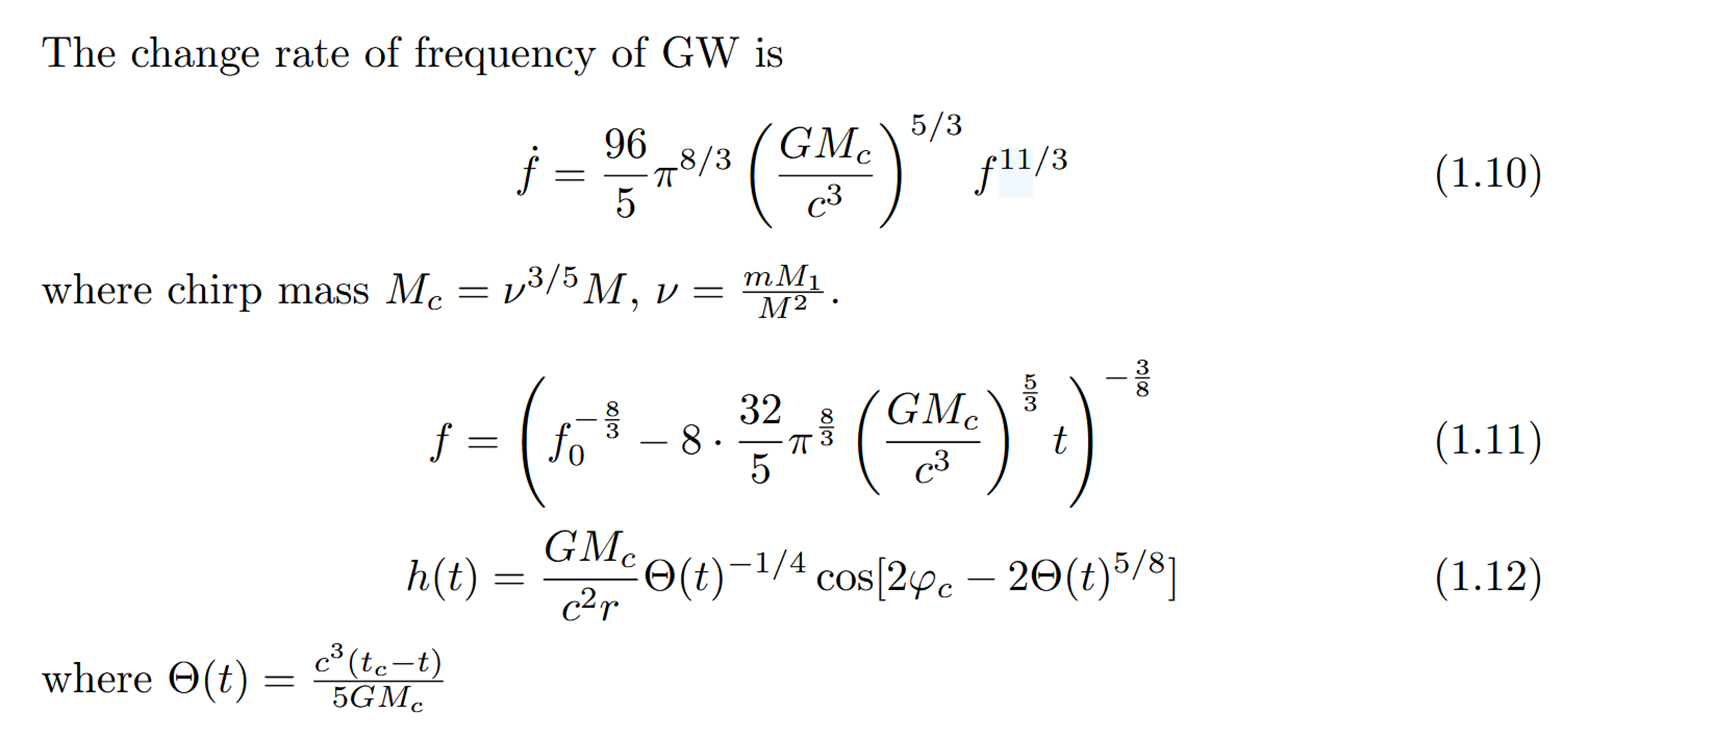
#### 透镜公式
- 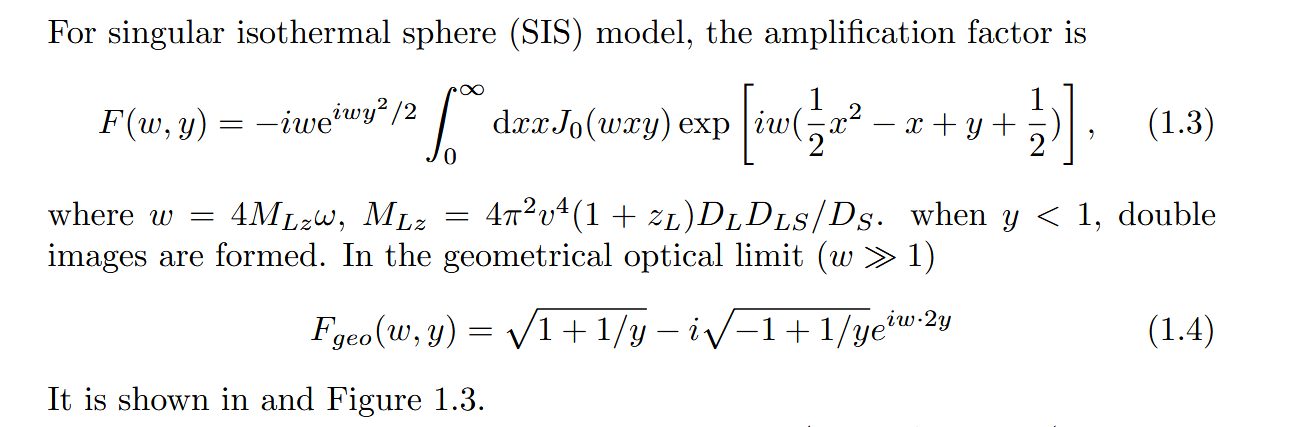
#### 待观测数据
- 所需探测范围
    - 信号：
        - r:1e24 ~ 3e24
        - Mc:1e31 ~ 2e31
        - tc: 0 ~ 10
        - phi_c: -2*np.pi ~ 2*np.pi
    - 透镜：
        - w :1e32 ~ 1e37
        - y:0~1

3.086e+24


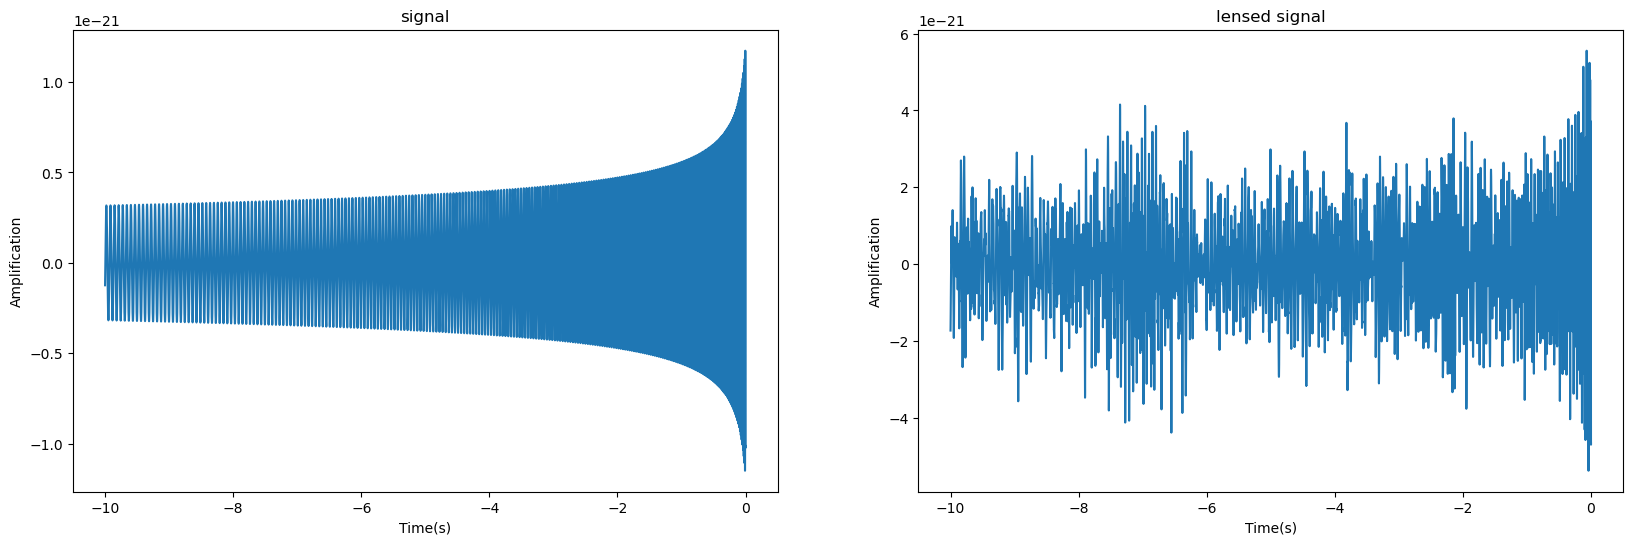

In [84]:
# 生成SIS模型波形

# 常量定义
# nsamples = 200000
# samples = 20000
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

# 变量定义
# 定义质量变量
M1 = 10 * M_sun
M2 = 12 * M_sun
M = (M1 + M2)
v = M1 * M2 / M ** 2 # 质量比
M_c = v ** (3 / 5) * M  # 啁啾质量
r = 1e8 * pc # 引力波源到观测者的距离  100Mpc
t_c = 0.05 # 合并时间
phi_c = -1/2 * np.pi # 合并时刻的相位
t = np.linspace(-10,0,200000)

print(r)
# 定义引力波信号函数
def generate_h_t(t,M_c,r,phi_c):
    theta_t= c**3 *(t_c - t) / (5 * G * M_c)
    h = G * M_c /(c ** 2 * r) * theta_t**(-1/4)*np.cos(2*phi_c - 2*theta_t**(5/8))
    return h
# 生成信号
h = generate_h_t(t,M_c,r,phi_c)
# 去掉信号inf的情况
h[-1] = h[-2] * 0.99
# 将信号转换到频域
h_f = np.fft.rfft(h)
# 生成频率
freqs = np.fft.rfftfreq(len(h),t[1] - t[0])

# 透镜参数定义
# Dl = 1e8 * pc  # 透镜到观测者的距离
# Ds = 1.5e8 * pc # 波源到透镜的距离
# Dls = Ds - Dl # 波源都观测者的距离
# v = 1e6 # 透镜系统的速度弥散
# zl = 0.5 # 红移
# Mlz = 4*np.pi**2 * v **4 *(1 + zl) * Dl * Dls / Ds
# print(Mlz / M_sun)
Mlz = 100 * M_sun

omega = 2 * np.pi * freqs
w = 4 *Mlz * omega
y = 0.1

# 定义光学极限的透镜化
def generate_f_geo(w,y):
    F_geo = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)
    return F_geo
# 生成透镜化，频域
F_geo = generate_f_geo(w,y)

# h_lens = h * F_geo
# 将信号透镜化 （频域）
lens_f = h_f * F_geo
# 逆傅里叶变换将频域信号转换为时域信号
h_lens = np.fft.irfft(lens_f)
# 画图
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(t,h.real,label = 'signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.title('signal')

plt.subplot(1,2,2)
plt.plot(t,h_lens.real,label = 'lensed signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.title('lensed signal')


plt.show()



## LIGO提供的PSD相关数据

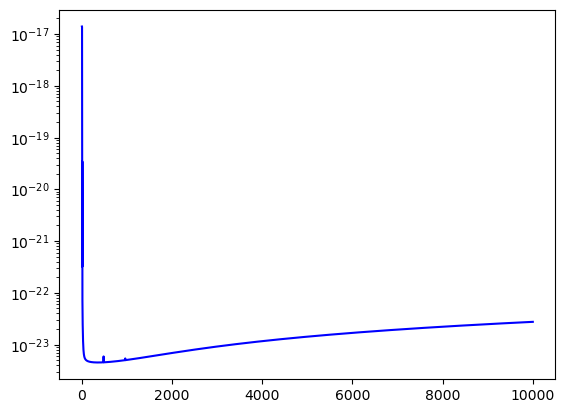

In [85]:
# 生成噪声

# 获取频率和噪声功率谱密度
freq_psd = np.loadtxt('aligo_design.txt')

posfreqs = freq_psd[:,0]
psd = freq_psd[:,1]
posfreqs[0] = 0

fig = plt.figure()
plt.plot(posfreqs, psd, 'b')
plt.yscale('log')
plt.show()


# 生成噪声并查看
- 总样本数为20w
- 采样率为2w
- 使用高斯噪声通过增益函数为aLIGO噪声功率谱密度的滤波器生成对应噪声
- 生成噪声之后将噪声振幅调整至1e-20

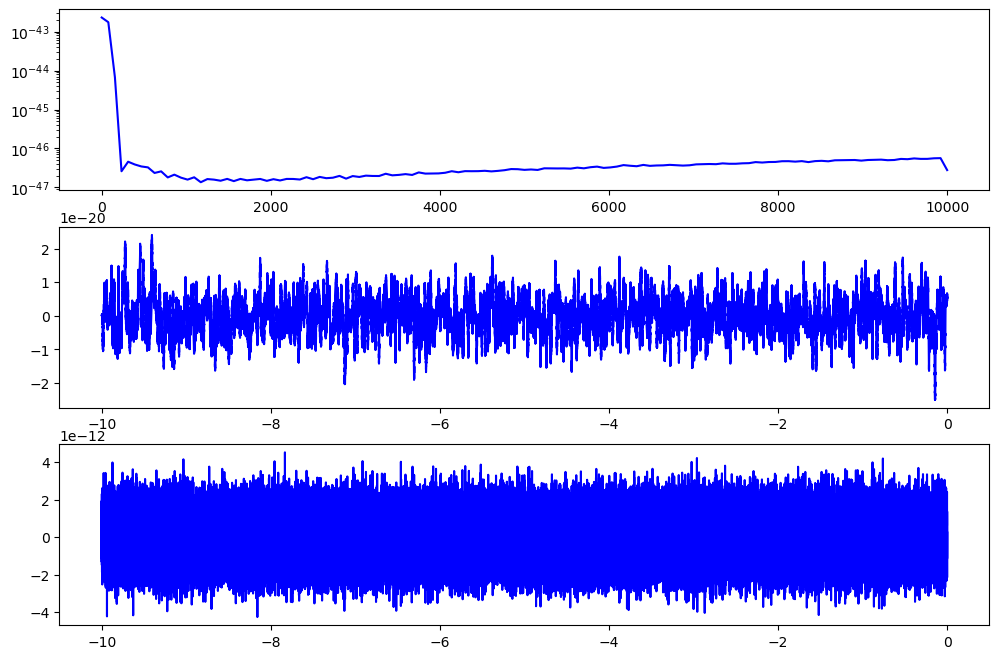

In [86]:
# 生成噪声
nsamples = 200000
samples = 20000
timeVec = t
# initial_noise = np.random.randn(nsamples)  * 1e-12
initial_noise = np.random.normal(0,1,nsamples) * 1e-12
filter_order = 300
output_noise = generate_target_psd_noise(filter_order,samples,psd,initial_noise,posfreqs)

# output_noise = output_noise * 1e-12 
# output_noise = output_noise[:len(h_lens)]

output_noise = output_noise[:len(timeVec)]
f,pxx = welch(output_noise,fs = samples,window = "hamming",nperseg=256,noverlap=None,nfft=None,detrend = False)

fig = plt.figure(figsize = (12,8))
plt.subplot(3,1,1)
plt.plot(f,pxx,'b')
plt.yscale('log')

plt.subplot(3,1,2)
plt.plot(timeVec,output_noise,'b')


plt.subplot(3,1,3)
plt.plot(timeVec,initial_noise,'b')
plt.show()


# t,f,w = stft(output_noise,fs = samples,nperseg = 256,noverlap = 128,nfft = 256)
# t_i,f_i,w_i = stft(initial_noise,fs = samples,nperseg = 256,noverlap = 128,nfft = 256)


# fig = plt.figure(figsize = (12,8))
# plt.subplot(2,1,1)
# plt.pcolormesh(t,f,np.abs(w),shading = 'goauraud')
# plt.pcolormesh(t_i,f_i,np.abs(w_i),shading = 'gouraud')
savemat('noise.txt',{'noise': output_noise})

# 将噪声混入信号
- 左图为透镜化之后的信号以及噪声情况
- 右图为透镜化之后的信号与混合数据的情况
- 取值情况为噪声约为信号的10-100倍强度
## 之后用数据代指       透镜化信号+噪声

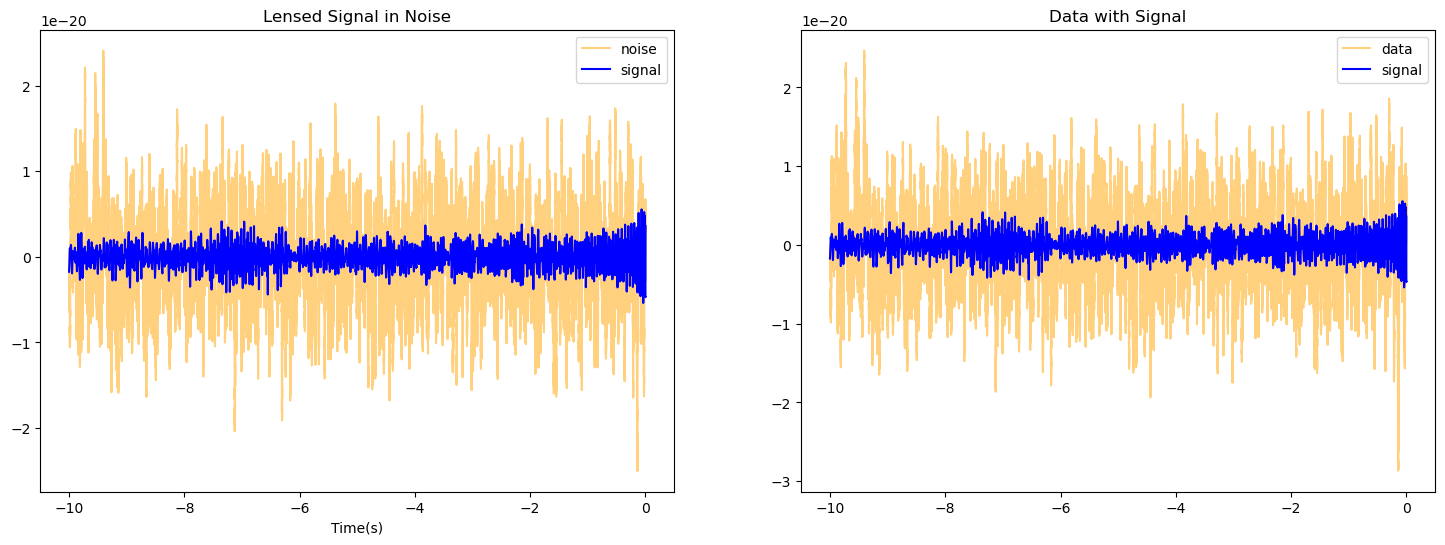

In [87]:
data = h_lens + output_noise

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 第一个子图
axs[0].plot(t, output_noise, "orange", label="noise", alpha=0.5)
axs[0].plot(t, h_lens, "blue", label='signal')
axs[0].set_xlabel("Time(s)")
axs[0].set_title("Lensed Signal in Noise")
axs[0].legend()

# 第二个子图
axs[1].plot(t, data, "orange", label="data", alpha=0.5)
axs[1].plot(t, h_lens, "blue", label='signal')
axs[1].set_title("Data with Signal")
axs[1].legend()

plt.show()

savemat('data.txt',{'data':data,'samples':samples})

# 绘制噪声与数据的功率谱密度
- 蓝色线代表总数据
- 橙色线代表纯噪声


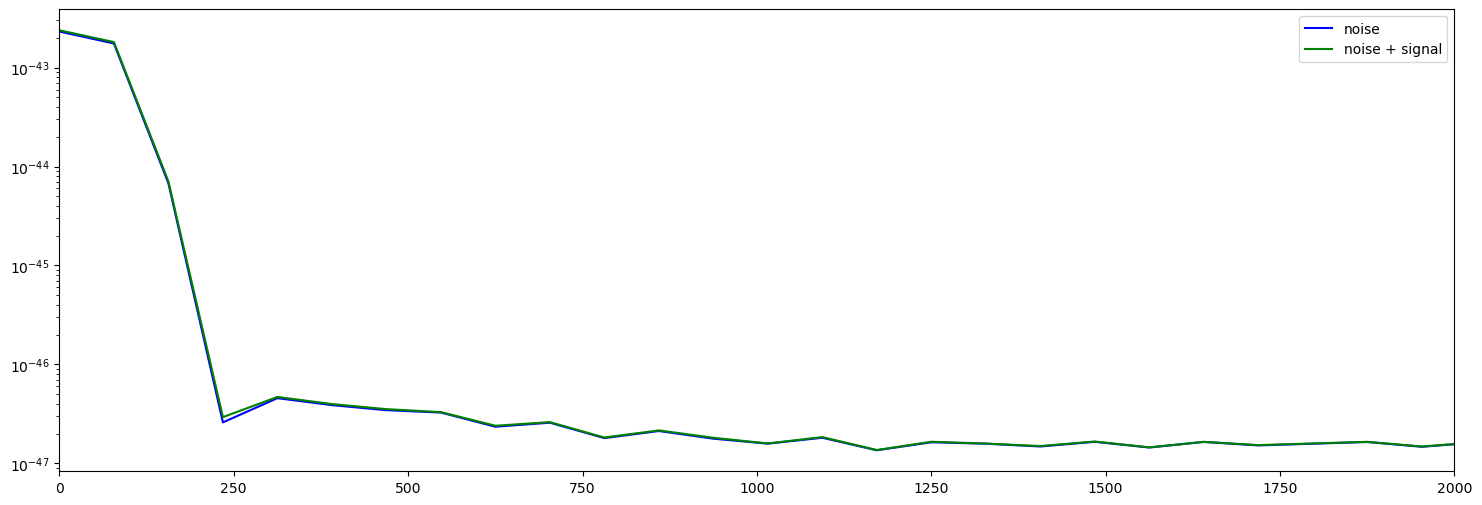

In [88]:
[f_data,pxx_data] = welch(data,fs = samples,window = "hamming",nperseg=256,noverlap=None,nfft=None,detrend = False)

fig = plt.figure(figsize=(18,6))
plt.plot(f,pxx,'blue',label = 'noise')
plt.plot(f_data,pxx_data,"green",label = 'noise + signal')
plt.yscale('log')
plt.legend()
plt.xlim(0,2000)
plt.show()

In [89]:
# 查看数据是否可以调用
data = loadmat("data.mat")
noise = loadmat("noise.mat")

samples_data = data['samples'][0]
dataY = data['data'][0]
dataY[-1] = dataY[-2] * 0.999
noise_y = noise['noise'][0]
dataY_FFT = np.fft.fft(dataY)
print(np.any(np.isinf(dataY_FFT)))

False


## 信噪比
- 在学习信噪比时看到的一个很好理解的视频
    - https://www.bilibili.com/video/BV1NG411b7qD/?spm_id_from=333.1391.0.0&vd_source=6653954c04b5fa19db6e649a79e0d4dd

In [90]:
# 计算信噪比
llrH0 = np.zeros(1000)
for lp in range(len(llrH0)):
    llrH0[lp] = innerprodpsd(noise_y,h_lens,samples_data,freqs)
llrH1 = np.zeros(1000)
for lp in range(len(llrH1)):
    llrH1[lp] = innerprodpsd(dataY,h_lens,samples_data,freqs)

estSNR = (np.mean(llrH1) - np.mean(llrH0)) / np.std(llrH0)

print(estSNR)
